# Time dependent ITER simulation

In [2]:
using Plots;
using FUSE
FUSE.ProgressMeter.ijulia_behavior(:clear);

Precompiling FUSE
  ✓ FUSE
  1 dependency successfully precompiled in 22 seconds. 642 already precompiled.


## Machine configuration

First we want to define the machine we'll working with..

One may design a machine directly within FUSE or (like in this case) take an experimental configurations from a ODS.

In [3]:
ini, act = FUSE.case_parameters(:ITER; init_from=:ods);

In [4]:
chk = FUSE.Checkpoint(); # checkpointing allows us to run mutliple times the same JupyterNotebook cell without everytime having to restart from scratch

dd = IMAS.dd()
@time dd = FUSE.init(dd, ini, act);

# FUSE.ActorWholeFacility(dd, act); # if we were to design a machine

chk[:hw_init] = dd, ini, act;

[ Info: HCD
[ Info:  SimpleEC
[ Info:  SimpleIC
[ Info:  SimpleLH
[ Info:  SimpleNB
[ Info:  SimplePellet
[ Info: Current
[ Info:  SteadyStateCurrent
[ Info: CXbuild


 63.885488 seconds (303.60 M allocations: 20.284 GiB, 5.62% gc time, 98.79% compilation time: <1% of which was recompilation)


## Time-dependent modeling

Once the machine is designed/configured we start to think about what plasma will we want to simulate.

In `ini` we define quantities to be time dependent by assining functions of `(t)` instead of scalar quantities.

FUSE defines convenience functions that can be used for pulse shaping: `step(t)`, `pulse(t)`, `ramp(t)`, `trap(t, ramp_fraction)`, `gaus(t, order)`, `beta(t, mode)`.

`ini.time.simulation_start` is used to set at what time the simulation should begin.

In [11]:
dd = chk[:hw_init].dd

ini, _ = FUSE.case_parameters(:ITER; init_from=:scalars, time_dependent=true);

ini.time.simulation_start = 50.0;

# the same ip(t) can be defined with unit pulse shaping functions...
ini.equilibrium.ip = t -> ramp(t / 10.0) * 13E6 + ramp((t - 100) / 100) * 2E6;

# ...or by a `sequence(t, t_y_tuple_sequence)`
ini.equilibrium.ip = t -> sequence(t, [(0.0, 0.0), (10.0, 13.0E6), (100.0, 13.0E6), (200.0, 15.0E6)]);

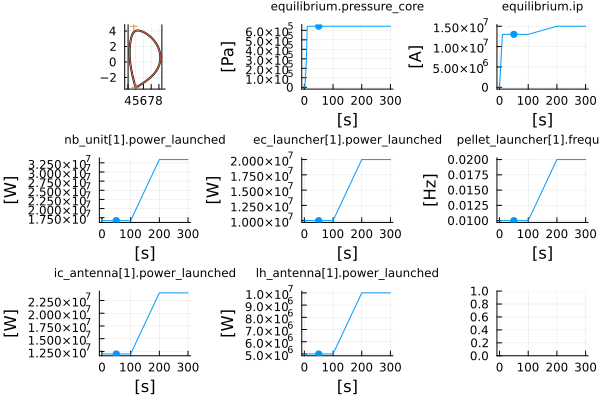

In [9]:
plot(ini)

`init()` here is used to populate `dd.pulse_schedule` from the time-dependent `ini` that we defined above

In [ ]:
FUSE.init(dd, ini, act; initialize_hardware=false);

chk[:tinit] = (dd, ini, act);

In [ ]:
using Interact
@manipulate for time0 in ini.time.pulse_shedule_time_basis
    plot(dd.pulse_schedule; time0, ini.time.simulation_start)
end

In [ ]:
FUSE.plot_plasma_overview(dd, dd.global_time; min_power=1E6, aggregate_radiation=true)

Our simulation should start in a self-consistent state. For this, we call the `ActorStationaryPlasma`

In [ ]:
dd, ini, act = chk[:tinit]

act.ActorStationaryPlasma.convergence_error = 2E-2
act.ActorStationaryPlasma.max_iter = 5

act.ActorCoreTransport.model = :FluxMatcher

act.ActorFluxMatcher.verbose = true

FUSE.ActorStationaryPlasma(dd, act; do_plot=false, verbose=true)
chk[:stationary] = (dd, ini, act);

In [ ]:
FUSE.plot_plasma_overview(dd, dd.global_time; min_power=1E6, aggregate_radiation=true)

Now we're ready to actually start the time-dependent simulation

In [ ]:
FUSE.ProgressMeter.ijulia_behavior(:clear)

dd, ini, act = chk[:stationary]

# For people interested in controls, the FuseExchangeProtocol can be used run a co-simulation with a controller external to FUSE
# IMAS.fxp_connect(dd)

act.ActorDynamicPlasma.Nt = 60
act.ActorDynamicPlasma.Δt = 300.0

act.ActorDynamicPlasma.evolve_current = true
act.ActorDynamicPlasma.evolve_equilibrium = true
act.ActorDynamicPlasma.evolve_transport = true
act.ActorDynamicPlasma.evolve_hcd = true
act.ActorDynamicPlasma.evolve_pf_active = true
act.ActorDynamicPlasma.evolve_pedestal = true

act.ActorDynamicPlasma.ip_controller = true
act.ActorDynamicPlasma.time_derivatives_sources = true

FUSE.ActorDynamicPlasma(dd, act; verbose=false);

chk[:time_dep_dt] = dd, ini, act;

Here's some plotting

In [ ]:
using Interact

time = dd.core_sources.time

prog = FUSE.ProgressMeter.Progress(length(time))
a = @animate for (k, time0) in enumerate(dd.core_sources.time)
    FUSE.ProgressMeter.next!(prog; showvalues=(("k",k), ("time",time0)))

# @manipulate for time0 in time

    FUSE.plot_plasma_overview(dd, time0; min_power=1E6, aggregate_radiation=true)
end

In [ ]:
#g = gif(a, "ITER_time_dep.gif", fps=12)
g = gif(a; fps=12)
display(g)